In [88]:
# compare phase vs. percent transition
# compare amplitude vs. percent transition

In [89]:
import sys
import rosbag
import matplotlib.pyplot as plt
import numpy as np

In [90]:
# obtain percent transition vs. time
def getWeights(filename):
    weights = []
    times = []
    bag = rosbag.Bag(filename)
    for topic, msg, t in bag.read_messages(topics=["/roboy_dep/linear_combination"]):
        weights.append(msg.weights)
        times.append(t.to_sec())
    bag.close()
    return np.array(weights), np.array(times)

In [91]:
filename = "/home/roboy/dep_data/data/combination/10FB04FS_04FB10FS_200s_2017-10-18-12-50-31.bag"

In [92]:
weights, times = getWeights(filename)

In [93]:
# obtain data from file
def getData(filename):
    position_to_rads = 2.0*3.14159/(2000.0*53.0);
    displacement_to_N = 0.237536
    time = []
    pos = []
    force = []
    bag = rosbag.Bag(filename)
    for topic, msg, t in bag.read_messages(topics=["/roboy/middleware/MotorStatus"]):
        pos.append(msg.position)
        force.append(msg.displacement)
        time.append(t.to_sec())
    bag.close()
    time = np.array(time)
    pos = np.array(pos)*position_to_rads
    force = np.array(force)*displacement_to_N
    return time, pos, force

In [94]:
time, pos, force = getData(filename)

In [95]:
# need to remove bit of recording before and after actual experiment
# inspect plot and provide approximate cutoff times
t_start = 4.3
t_end = 205.0

In [96]:
# obtain minima of given muscle data
from scipy.signal import argrelextrema
def getPeaks(position):
    indices = np.array(argrelextrema(position, np.less))
    return indices

We can calculate an approximate phase of a given muscle relative to its counter part in a given behavior by: 
1. calculating the relative position of the muscle in comparison with an unchanging muscle through comparing time difference between peaks, 
2. calculating the original time difference between peaks for the muscle in the original behavior, and 
3. calculating a phase by comparing the total time difference relative to the period

##### Obtaining muscle and reference peak indices

In [97]:
def movingAvg(data, window_size):
    a = []
    for i in range(len(data)):
        a.append(np.ma.average(data[np.clip(i-int(window_size/2),0,len(data)):np.clip(i+int(window_size/2),0,len(data))]))
    return np.array(a)

In [98]:
# remove indices above/below cutoff times from peaks
def trim(indices,t_start,t_end):
    i_start = int(t_start/0.020)
    i_end = int(t_end/0.020)
    indices[indices < i_start] = 0
    indices[indices > i_end] = 0
    indices = np.trim_zeros(indices)
    return indices

In [99]:
# For FB to FS
# change muscle = muscle 2 i.e. position[:,3]
# take moving average in attempt to differentiate two consecutive points with the same value
muscle = movingAvg(pos[:,3],3)
muscle_peaks = getPeaks(muscle)[0]
muscle_peaks = trim(muscle_peaks,t_start,t_end)
# reference muscle = muscle 5 i.e. position[:,5]
ref = movingAvg(pos[:,5],3)
ref_peaks = getPeaks(ref)[0]
ref_peaks = trim(ref_peaks,t_start,t_end)

# target muscle has 3 peaks after end of experiment -> remove these
#muscle_peaks = muscle_peaks[:-3]
# reference muscle has 4 peaks after end of experiment -> remove these
#ref_peaks = ref_peaks[:-2]


In [118]:
print muscle_peaks, ref_peaks

[  309   444   579   714   849   984  1119  1254  1389  1523  1658  1792
  1927  2061  2196  2330  2464  2598  2732  2866  3000  3134  3268  3402
  3537  3671  3805  3939  4073  4208  4342  4477  4612  4747  4883  5019
  5156  5296  5349  5484  5619  5754  5888  6023  6157  6292  6427  6562
  6696  6831  6966  7101  7235  7370  7505  7639  7774  7909  8043  8178
  8313  8448  8583  8718  8853  8988  9124  9259  9395  9531  9667  9803
  9939 10075 10211] [  244   380   516   651   786   921  1057  1192  1326  1461  1596  1731
  1865  2000  2134  2269  2403  2538  2672  2806  2941  3075  3209  3344
  3478  3612  3747  3881  4015  4150  4285  4419  4554  4688  4823  4958
  5092  5227  5361  5496  5631  5765  5900  6035  6169  6304  6438  6573
  6708  6842  6976  7111  7245  7380  7514  7648  7783  7917  8052  8186
  8321  8456  8590  8725  8860  8995  9131  9266  9401  9537  9672  9808
  9944 10080 10216]


In [101]:
avg_dist = np.ma.average((ref_peaks-np.roll(ref_peaks,1))[1:])
std_dist = np.std((ref_peaks-np.roll(ref_peaks,1))[1:])
print avg_dist, std_dist

134.756756757 0.653696574186


##### Behavior period and reference distance

In [102]:
avg_period = (1358.5-717.0)/5
dist = 758.0 - 808.0

##### Phase plot

In [125]:
y = ((muscle_peaks-ref_peaks))/avg_dist*360#-dist)#/avg_dist*360
y

array([ 173.64620939,  170.97472924,  168.3032491 ,  168.3032491 ,
        168.3032491 ,  168.3032491 ,  165.63176895,  165.63176895,
        168.3032491 ,  165.63176895,  165.63176895,  162.96028881,
        165.63176895,  162.96028881,  165.63176895,  162.96028881,
        162.96028881,  160.28880866,  160.28880866,  160.28880866,
        157.61732852,  157.61732852,  157.61732852,  154.94584838,
        157.61732852,  157.61732852,  154.94584838,  154.94584838,
        154.94584838,  154.94584838,  152.27436823,  154.94584838,
        154.94584838,  157.61732852,  160.28880866,  162.96028881,
        170.97472924,  184.33212996,  -32.05776173,  -32.05776173,
        -32.05776173,  -29.38628159,  -32.05776173,  -32.05776173,
        -32.05776173,  -32.05776173,  -29.38628159,  -29.38628159,
        -32.05776173,  -29.38628159,  -26.71480144,  -26.71480144,
        -26.71480144,  -26.71480144,  -24.0433213 ,  -24.0433213 ,
        -24.0433213 ,  -21.37184116,  -24.0433213 ,  -21.37184

In [126]:
x = np.around(times[muscle_peaks]-times[0],2)

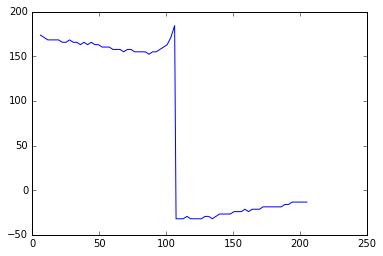

In [127]:
plt.figure(1)
plt.plot(x,y)
plt.show()